In [ ]:
%autosave 1

Autosaving every 1 seconds


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import pathlib
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
data_dir = '/content/drive/MyDrive/Thermal Map Image Dataset (1)'
data_dir = pathlib.Path(data_dir)
train_dir = '/content/drive/MyDrive/Thermal Map Image Dataset (1)/split dataset/train'
train_dir = pathlib.Path(train_dir)
test_dir = '/content/drive/MyDrive/Thermal Map Image Dataset (1)/split dataset/test'
test_dir = pathlib.Path(test_dir)
valid_dir = '/content/drive/MyDrive/Thermal Map Image Dataset (1)/split dataset/val'
valid_dir = pathlib.Path(valid_dir)

In [ ]:
batch_size = 16
img_height = 224
img_width = 224

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
  )

Found 6101 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_dir,
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 1743 files belonging to 2 classes.


In [ ]:
test_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode = "categorical",
    seed=123,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=1, shuffle = False)

Found 872 files belonging to 2 classes.


In [ ]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [ ]:
class_names = test_ds.class_names
print(class_names)

['Healthy', 'Sick']


In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16, 2)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

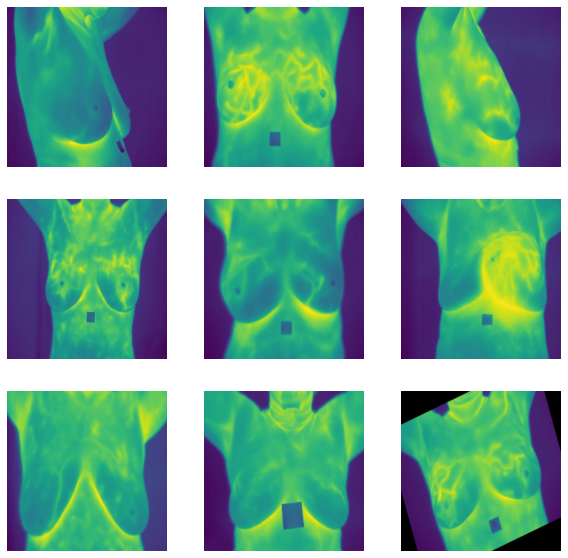

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    #pooling="max",
    #classifier_activation="softmax",
)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
prediction_layer = tf.keras.layers.Dense(2,activation=tf.keras.activations.softmax)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(inputs, training=False)
# x = global_average_layer(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#base_learning_rate = 0.0001
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
filepath = "/content/drive/MyDrive/Thermal Map Image Dataset/Models/MobileNetV2/MobileNetV2.h5"

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor="val_binary_accuracy", 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode="max", 
    save_freq="epoch"
    )

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=False
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_delta=1e-3,
    min_lr = 5*1e-12,
    )

callbacks = [model_save,  reduce_lr]#, early_stop,]

In [ ]:
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics='binary_accuracy')

In [ ]:
history =  model.fit(
    train_ds, 
    validation_data=val_ds, 
    #steps_per_epoch=StepsPerEpoch, 
    epochs = 20,
    callbacks= callbacks, 
    #validation_steps=ValidationSteps, 
    use_multiprocessing= True
    )

Epoch 1/20
382/382 [==============================] - 676s 2s/step - loss: 0.5654 - binary_accuracy: 0.6864 - val_loss: 0.4709 - val_binary_accuracy: 0.7579 - lr: 1.0000e-04
Epoch 2/20
382/382 [==============================] - 22s 57ms/step - loss: 0.4780 - binary_accuracy: 0.7509 - val_loss: 0.4392 - val_binary_accuracy: 0.7785 - lr: 1.0000e-04
Epoch 3/20
382/382 [==============================] - 22s 57ms/step - loss: 0.4492 - binary_accuracy: 0.7674 - val_loss: 0.4172 - val_binary_accuracy: 0.7946 - lr: 1.0000e-04
Epoch 4/20
382/382 [==============================] - 22s 57ms/step - loss: 0.4267 - binary_accuracy: 0.7807 - val_loss: 0.3997 - val_binary_accuracy: 0.8078 - lr: 1.0000e-04
Epoch 5/20
382/382 [==============================] - 22s 57ms/step - loss: 0.4081 - binary_accuracy: 0.7953 - val_loss: 0.3853 - val_binary_accuracy: 0.8199 - lr: 1.0000e-04
Epoch 6/20
382/382 [==============================] - 22s 57ms/step - loss: 0.3924 - binary_accuracy: 0.8079 - val_loss: 0.373

In [ ]:
export_dir='/content/drive/MyDrive/Thermal Map Image Dataset/Models/MobileNetV2/MobileNetV2_save_model/'
model.save(export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thermal Map Image Dataset/Models/MobileNetV2/MobileNetV2_save_model/assets


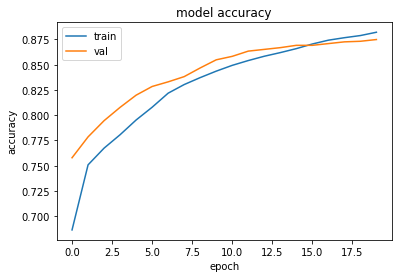

In [ ]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



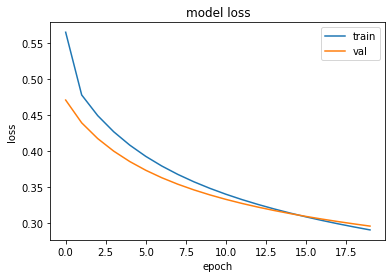

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()



In [ ]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)



872/872 [==============================] - 121s 137ms/step


In [ ]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]




0

In [ ]:
conf_mat = confusion_matrix(rounded_labels, y_pred)

classes = class_names


classes

['Healthy', 'Sick']

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



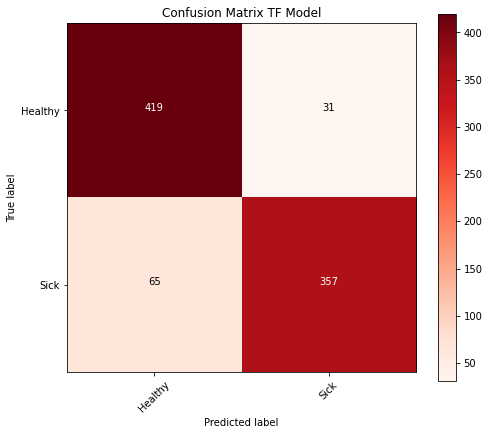

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TF Model')
fig1.savefig('/content/drive/MyDrive/Thermal Map Image Dataset/Models/MobileNetV2/cm_wo_norm_1.png')
plt.show()



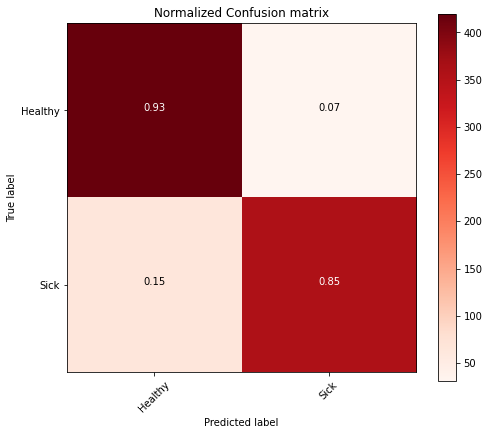

In [ ]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('/content/drive/MyDrive/Thermal Map Image Dataset/Models/MobileNetV2/cm_norm_1.jpg')
plt.show()



In [ ]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.87      0.93      0.90       450
        Sick       0.92      0.85      0.88       422

    accuracy                           0.89       872
   macro avg       0.89      0.89      0.89       872
weighted avg       0.89      0.89      0.89       872



# Fine-Tuning

In [ ]:
filepath = "/content/drive/MyDrive/Thermal Map Image Dataset/Models/MobileNetV2/MobileNetV2_finetune.h5"

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor="val_binary_accuracy", 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode="max", 
    save_freq="epoch"
    )

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=False
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_delta=1e-3,
    min_lr = 5*1e-12,
    )

callbacks = [model_save,  reduce_lr]#, early_stop,]

In [ ]:
base_model.trainable = True
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics='binary_accuracy')

In [ ]:
history =  model.fit(
    train_ds, 
    validation_data=val_ds, 
    #steps_per_epoch=StepsPerEpoch, 
    epochs = 20,
    callbacks= callbacks, 
    #validation_steps=ValidationSteps, 
    use_multiprocessing= True
    )

Epoch 1/20
382/382 [==============================] - 94s 227ms/step - loss: 0.3628 - binary_accuracy: 0.8382 - val_loss: 0.1972 - val_binary_accuracy: 0.9099 - lr: 1.0000e-04
Epoch 2/20
382/382 [==============================] - 85s 222ms/step - loss: 0.1488 - binary_accuracy: 0.9394 - val_loss: 0.1042 - val_binary_accuracy: 0.9621 - lr: 1.0000e-04
Epoch 3/20
382/382 [==============================] - 84s 219ms/step - loss: 0.1061 - binary_accuracy: 0.9574 - val_loss: 0.1198 - val_binary_accuracy: 0.9484 - lr: 1.0000e-04
Epoch 4/20
382/382 [==============================] - 85s 223ms/step - loss: 0.0725 - binary_accuracy: 0.9718 - val_loss: 0.0814 - val_binary_accuracy: 0.9702 - lr: 1.0000e-04
Epoch 5/20
382/382 [==============================] - 84s 219ms/step - loss: 0.0619 - binary_accuracy: 0.9759 - val_loss: 0.0874 - val_binary_accuracy: 0.9667 - lr: 1.0000e-04
Epoch 6/20
382/382 [==============================] - 84s 219ms/step - loss: 0.0481 - binary_accuracy: 0.9802 - val_loss

In [ ]:
export_dir='/content/drive/MyDrive/Thermal Map Image Dataset/Models/MobileNetV2/MobileNetV2_save_model_finetuned/'
model.save(export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thermal Map Image Dataset/Models/MobileNetV2/MobileNetV2_save_model_finetuned/assets


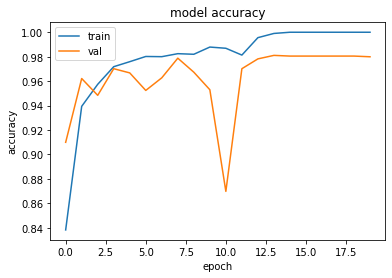

In [ ]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

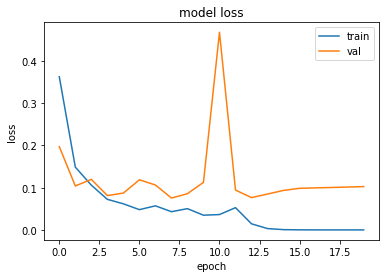

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)

872/872 [==============================] - 12s 13ms/step


In [ ]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)
rounded_labels=np.argmax(y_true, axis=1)
rounded_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
conf_mat = confusion_matrix(rounded_labels, y_pred)

classes = class_names


classes

['Healthy', 'Sick']

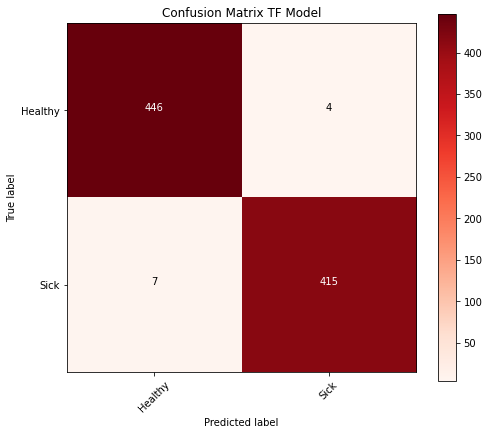

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TF Model')
fig1.savefig('/content/drive/MyDrive/Thermal Map Image Dataset/Models/MobileNetV2/cm_wo_norm.png')
plt.show()



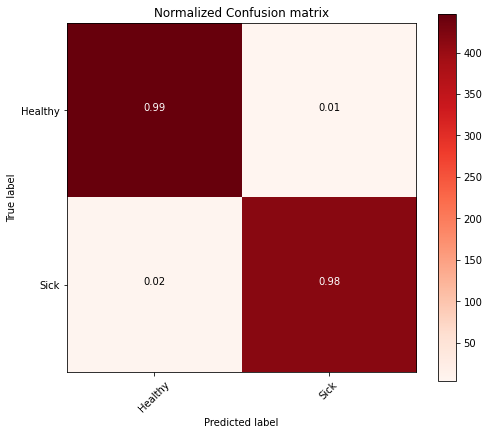

In [ ]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('/content/drive/MyDrive/Thermal Map Image Dataset/Models/MobileNetV2/cm_norm.jpg')
plt.show()



In [ ]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.98      0.99      0.99       450
        Sick       0.99      0.98      0.99       422

    accuracy                           0.99       872
   macro avg       0.99      0.99      0.99       872
weighted avg       0.99      0.99      0.99       872



##TFLite

In [ ]:
SAVED_MODEL = '/content/drive/MyDrive/Thermal Map Image Dataset (1)/Models/MobileNetV2/MobileNetV2_finetune.h5'


##Types of conversions
https://www.tensorflow.org/lite/performance/post_training_quantization

In [ ]:
import tensorflow as tf

model_save = tf.keras.models.load_model(SAVED_MODEL)
converter = tf.lite.TFLiteConverter.from_keras_model(model_save)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
#converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
open("/content/drive/MyDrive/Thermal Map Image Dataset (1)/Models/MobileNetV2/tflite/mobilenetv2_INT8.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp7dj4s5gc/assets


INFO:tensorflow:Assets written to: /tmp/tmp7dj4s5gc/assets


2648576

In [ ]:
# Load TFLite model and allocate tensors.
import tensorflow as tf
import numpy as np
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Thermal Map Image Dataset (1)/Models/MobileNetV2/tflite/mobilenetv2_INT8.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

NameError: ignored

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 177,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 2], dtype=int32),
  'shape_signature': array([-1,  2], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_2:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 2]
type: <class 'numpy.float32'>


In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (1, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 5))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_2:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 2]
type: <class 'numpy.float32'>


In [ ]:
val_image_batch, val_label_batch = next(iter(test_ds))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (1, 224, 224, 3)


In [ ]:
y_true_labels = []
y_pred_labels = []
for val_image_batch, val_label_batch in test_ds:
  #y_true_labels.append(val_label_batch)
  #print(val_image_batch.shape,val_label_batch)
  interpreter.set_tensor(input_details[0]['index'], val_image_batch)
  interpreter.invoke()
  tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
  y_pred_labels.append(np.argmax(tflite_model_predictions[0]))

In [ ]:
y_pred_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
conf_mat = confusion_matrix(rounded_labels, y_pred_labels)
classes = class_names
classes

['Healthy', 'Sick']

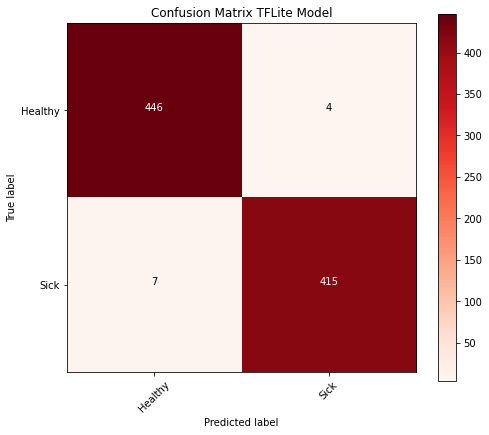

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TFLite Model')
fig1.savefig('/content/drive/MyDrive/Thermal Map Image Dataset (1)/Models/MobileNetV2/tflite/INT8TFlite_cm.png')
plt.show()

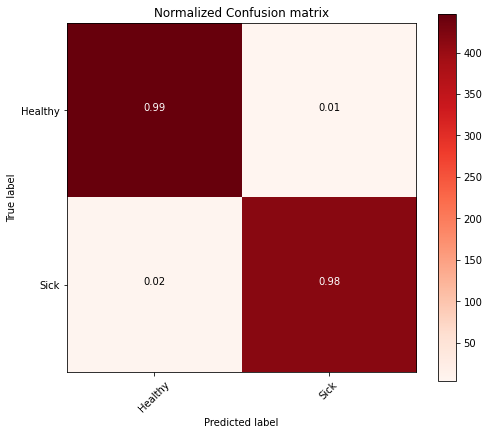

In [ ]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('/content/drive/MyDrive/Thermal Map Image Dataset (1)/Models/MobileNetV2/tflite/INT8TFlite_cm_norm.jpg')
plt.show()

In [ ]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred_labels, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.98      0.99      0.99       450
        Sick       0.99      0.98      0.99       422

    accuracy                           0.99       872
   macro avg       0.99      0.99      0.99       872
weighted avg       0.99      0.99      0.99       872

